In [18]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# 1. Chargement et nettoyage
df = pd.read_excel(r"C:\Users\Pc\Desktop\Python S2\Online Retail.xlsx")

# Nettoyage
df.dropna(subset=['InvoiceNo', 'Description', 'CustomerID'], inplace=True)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]  # Retirer les retours produits

# ======================================
# PARTIE 1 : RÈGLES D’ASSOCIATION
# ======================================

# Créer un panier (toutes ventes, tous pays)
df_france = df[df['Country'] == 'France']

basket_fr = (df_france
             .groupby(['InvoiceNo', 'Description'])['Quantity']
             .sum().unstack().fillna(0))

basket_fr = basket_fr.applymap(lambda x: 1 if x > 0 else 0)

# --- Apriori ---
frequent_itemsets_ap = apriori(basket_fr, min_support=0.01, use_colnames=True)
rules_ap = association_rules(frequent_itemsets_ap, metric="lift", min_threshold=1)
print(rules_ap[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

C:\Users\Pc\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\Pc\anaconda3\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
C:\Users\Pc\AppData\Local\Temp\ipykernel_7368\2539636184.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_fr = basket_fr.applymap(lambda x: 1 if x > 0 else 0)
C:\Users\Pc\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance

                         antecedents                        consequents  \
0               ( DOLLY GIRL BEAKER)  (CHARLOTTE BAG DOLLY GIRL DESIGN)   
1  (CHARLOTTE BAG DOLLY GIRL DESIGN)               ( DOLLY GIRL BEAKER)   
2               ( DOLLY GIRL BEAKER)        (DOLLY GIRL CHILDRENS BOWL)   
3        (DOLLY GIRL CHILDRENS BOWL)               ( DOLLY GIRL BEAKER)   
4               ( DOLLY GIRL BEAKER)         (DOLLY GIRL CHILDRENS CUP)   

    support  confidence       lift  
0  0.012853    0.555556   8.311966  
1  0.012853    0.192308   8.311966  
2  0.017995    0.777778  16.808642  
3  0.017995    0.388889  16.808642  
4  0.015424    0.666667  16.208333  


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Charger les données (remplacez par votre chemin de fichier)
df = pd.read_excel(r"C:\Users\Pc\Desktop\Python S2\Online Retail.xlsx")


# 1. Agrégation par client
customer_df = (df.groupby('CustomerID')
               .agg({
                   'Quantity': 'sum',
                   'UnitPrice': 'mean',
                   'InvoiceNo': pd.Series.nunique
               })
               .rename(columns={'InvoiceNo': 'NumPurchases'}))

# Calcul du montant total dépensé
customer_df['TotalSpent'] = customer_df['Quantity'] * customer_df['UnitPrice']
# Supprimer les valeurs négatives
customer_df = customer_df[(customer_df['Quantity'] > 0) & 
                         (customer_df['TotalSpent'] > 0)]

# 2. Nettoyage des outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] <= Q3 + 1.5*IQR) & (df[column] >= Q1 - 1.5*IQR)]

customer_df = remove_outliers(customer_df, 'Quantity')
customer_df = remove_outliers(customer_df, 'TotalSpent')


# 3. Normalisation des données
scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_df[['Quantity', 'UnitPrice', 'NumPurchases', 'TotalSpent']])

In [19]:
# 5. Clustering K-means (avec 3 clusters par défaut)
optimal_clusters = 3  # Ajustez selon la méthode du coude
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(customer_scaled)

# 6. Évaluation
print(f"Silhouette Score: {silhouette_score(customer_scaled, customer_df['Cluster']):.2f}")

Silhouette Score: 0.46


In [21]:
#Visualisation améliorée
plt.figure(figsize=(12,6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

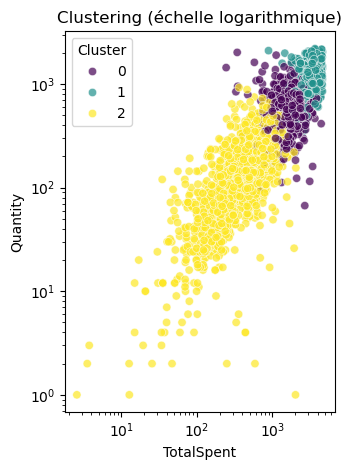

In [32]:
plt.subplot(1,2,2)
sns.scatterplot(data=customer_df, x='TotalSpent', y='Quantity', 
                hue='Cluster', palette='viridis', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title('Clustering (échelle logarithmique)')

plt.tight_layout()
plt.show()

In [27]:
# 8. Analyse des clusters
cluster_stats = customer_df.groupby('Cluster').agg({
    'Quantity': ['mean', 'median', 'count'],
    'TotalSpent': ['mean', 'median']
})
print("\nStatistiques par cluster:")
print(cluster_stats)


Statistiques par cluster:
            Quantity                 TotalSpent             
                mean  median count         mean       median
Cluster                                                     
0         608.118661   571.0   986  1728.733185  1649.964328
1        1233.207585  1186.0   501  3282.856135  3278.765470
2         185.679908   160.0  2165   532.925089   478.866667
